In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import io

from IPython.display import display
from PIL import Image
from IPython.display import HTML

RED 500 Green 2000 Blue 8000

In [2]:
# #频率
# Base_Freq = 500 #in Hz
# # 加载图像
# image_path = 'Red.jpg'

# #频率
# Base_Freq = 2000 #in Hz
# # 加载图像
# image_path = 'Green.jpg'

#频率
Base_Freq = 8000 #in Hz
# 加载图像
image_path = 'Blue.jpg'

In [3]:
#print(os.getcwd())

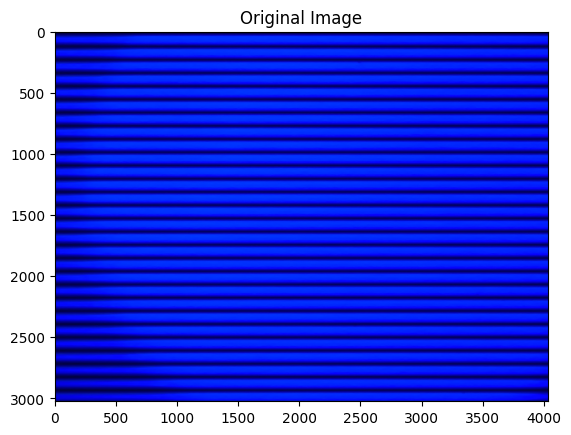

In [4]:

image = cv2.imread(image_path)

# 将图像从BGR转换为RGB以便于matplotlib显示
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 显示图像
plt.imshow(image_rgb)
plt.title('Original Image')
plt.show()

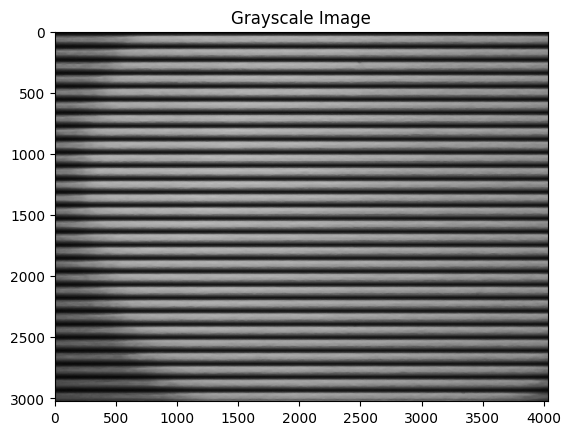

In [5]:
gray_image = cv2.normalize(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), None, 0, 255, cv2.NORM_MINMAX)

# 显示灰度图像
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.show()


中间 10% 列的 mean_projection: [ 70.43672457  62.60545906  55.9057072  ... 143.04218362 112.30521092
 100.24317618]


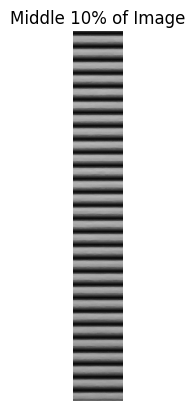

In [6]:
# 获取图像的高度和宽度
height, width = gray_image.shape

# 计算宽度的 10%
width_10_percent = int(width * 0.1)

# 计算中间部分的起始和结束列
start_col = (width - width_10_percent) // 2
end_col = start_col + width_10_percent

# 提取中间 10% 列的图像
middle_10_percent = gray_image[:, start_col:end_col]

# 计算中间 10% 列的平均值
mean_projection_middle = np.mean(middle_10_percent, axis=1)

# 打印结果
print("中间 10% 列的 mean_projection:", mean_projection_middle)

# 可视化中间 10% 区域（可选）
plt.imshow(middle_10_percent, cmap='gray')
plt.title('Middle 10% of Image')
plt.axis('off')
plt.show()

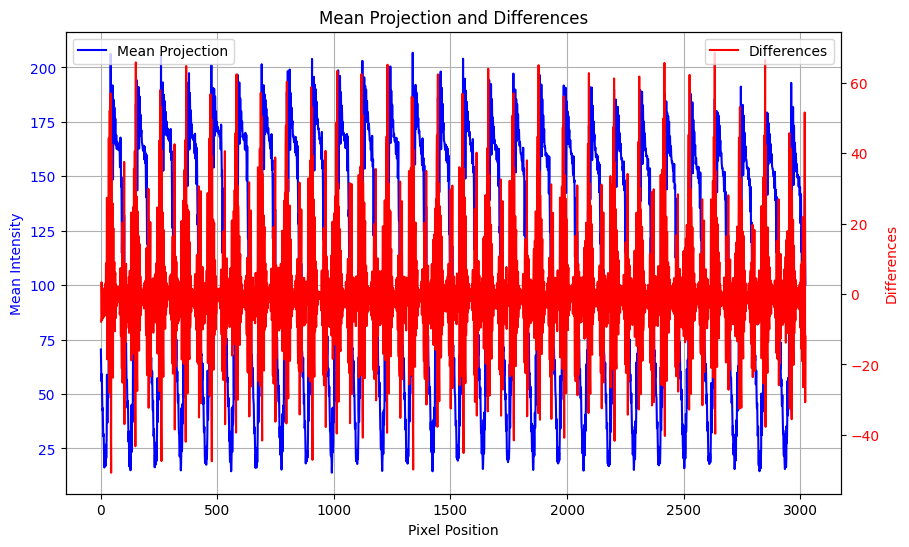

In [7]:
mean_projection = np.mean(middle_10_percent, axis=1)
differences = np.diff(mean_projection)
# 创建新的图形
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制 mean_projection
ax1.plot(mean_projection, label='Mean Projection', color='blue')
ax1.set_xlabel('Pixel Position')
ax1.set_ylabel('Mean Intensity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Mean Projection and Differences')

# 创建第二个 y 轴
ax2 = ax1.twinx()  
ax2.plot(range(1, len(mean_projection)), differences, label='Differences', color='red')
ax2.set_ylabel('Differences', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 添加图例（可选）
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 添加网格
ax1.grid()

# 显示图形
plt.show()

In [8]:
from scipy.ndimage import gaussian_filter1d 
sigma = 3
smoothed_projection_gaussian = gaussian_filter1d(mean_projection, sigma)



阈值: 100.22153427679193


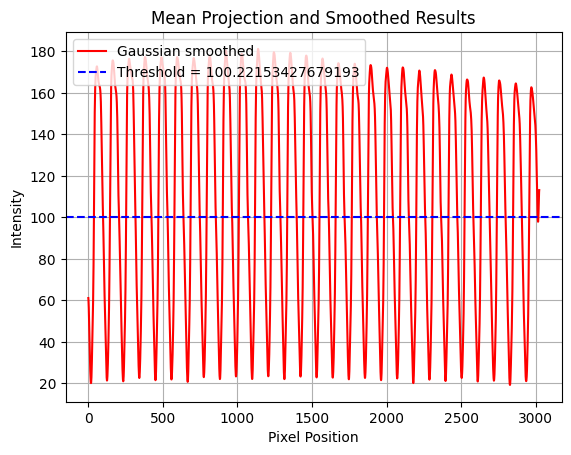

In [9]:
###### 步骤 3: 使用从大到小排列的最小 10% 值作为阈值
# sorted_projection = np.sort(smoothed_projection_gaussian)[::-1]  # 从大到小排序
# threshold_index = int(len(smoothed_projection_gaussian) * 0.60)  # 计算最小 10% 的索引
# threshold_value = sorted_projection[threshold_index]  # 获取阈值


threshold_value = (np.min(smoothed_projection_gaussian)+np.max(smoothed_projection_gaussian))/2


print(f"阈值: {threshold_value}")
# 绘制 Gaussian 滤波平滑结果
plt.plot(smoothed_projection_gaussian, label='Gaussian smoothed', color='red')
plt.axhline(y=threshold_value, color='blue', linestyle='--', label=f'Threshold = {threshold_value}')
# 添加标题和标签
plt.title('Mean Projection and Smoothed Results')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.legend(loc='upper left') 
plt.grid()

# 显示图形
plt.show()




In [10]:
np.savetxt("output.txt",smoothed_projection_gaussian,delimiter=',')

In [11]:
stripe_widths = []
current_width = 0
invert = bool(smoothed_projection_gaussian[0] > threshold_value)
for lightvalue in smoothed_projection_gaussian:
    if (lightvalue>threshold_value) ^ (not invert):  # 当前是条带
        current_width += 1
    else:  # 当前是背景
        if current_width > 0:
            stripe_widths.append(current_width)
            current_width = 1
            invert = not invert


# 掐头去尾            
trimmed_stripe_widths = stripe_widths[1:-1] 
# 如果元素个数为奇数，去除最后一个元素
if len(trimmed_stripe_widths) % 2 == 1:
    trimmed_stripe_widths = trimmed_stripe_widths[:-1]  # 去除最后一个元素
    
print(stripe_widths)
print(trimmed_stripe_widths)

[38, 61, 46, 62, 47, 63, 44, 63, 46, 62, 45, 61, 48, 62, 45, 62, 47, 62, 45, 62, 47, 63, 45, 62, 46, 64, 44, 62, 46, 62, 46, 60, 49, 62, 45, 61, 48, 59, 49, 58, 50, 60, 48, 59, 49, 59, 49, 59, 50, 59, 48, 59, 50, 59, 49, 57, 5]
[61, 46, 62, 47, 63, 44, 63, 46, 62, 45, 61, 48, 62, 45, 62, 47, 62, 45, 62, 47, 63, 45, 62, 46, 64, 44, 62, 46, 62, 46, 60, 49, 62, 45, 61, 48, 59, 49, 58, 50, 60, 48, 59, 49, 59, 49, 59, 50, 59, 48, 59, 50, 59, 49]


In [12]:
#RollingShutterTime = (image height / height of bands measured * number of bands measured)*(1000/BaseFreq) in ms
RollingShutterTime = (len(mean_projection))/sum(trimmed_stripe_widths)*(len(trimmed_stripe_widths) / 2) * (1000/Base_Freq)

In [13]:
# 使用 HTML 显示并设置为蓝色
HTML(f'<span style="color: blue;font-size: 40px;">{Base_Freq } RollingShutterTime: {RollingShutterTime} ms</span>')